
# HMM: Simulation

In this tutorial we will train a Hidden Markov Model (HMM) on simulated data. This tutorial covers:

1. Simulating HMM Data
2. Setting up the HMM
3. Training the HMM
4. Getting Inferred Model Parameters
5. Post-hoc Analysis

Note, this webpage does not contain the output of running each cell. See [OSF](https://osf.io/wc5sj) for the expected output.


## Simulating HMM Data
In this tutorial we will simulate data using a pre-specified HMM. A HMM has two sets of parameters:

- **The transition probablity matrix**. This is a matrix that contains the probability of a state transitioning to another state.
- **The observation model parameters**. Here, we will use a multivariate normal distribution for the observation model. Therefore, we need to specify the mean vector and covariance matrix that generates the data. Each state has its own mean vector and covariance matrix. In this tutorial we will assume the mean vector is zero for all states.

osl-dynamics has a simulation class that makes simulating HMM data easy: [simulation.hmm.HMM_MVN](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/simulation/hmm/index.html#osl_dynamics.simulation.hmm.HMM_MVN). Let's use this class to simulate some data. We will simulate HMM data with 11 channels and 5 hidden states.



In [2]:
from osl_dynamics import simulation

# Initiate the HMM_MVN class simulates HMM data
sim = simulation.HMM_MVN(
    n_samples=25600,
    n_states=5,
    n_channels=11,
    trans_prob="sequence",
    stay_prob=0.9,  # diagonal of the transition probability matrix
    means="zero",
    covariances="random",  # will automatically generate some covariances 'randomly'
    #random_seed=123,
)

# Before training the model we want to standardize (z-transform) the data.
# The HMM_MVN class has a method we can use to do this.
sim.standardize()

# We can access the simulated data using the time series attribute
ts = sim.time_series
print(ts.shape)

(25600, 11)


Let's examine the HMM parameters we have used to generate the data. First, let's look at the transition probability matrix used to simulate the hidden state time course:



(<Figure size 640x480 with 2 Axes>, array([[<Axes: >]], dtype=object))

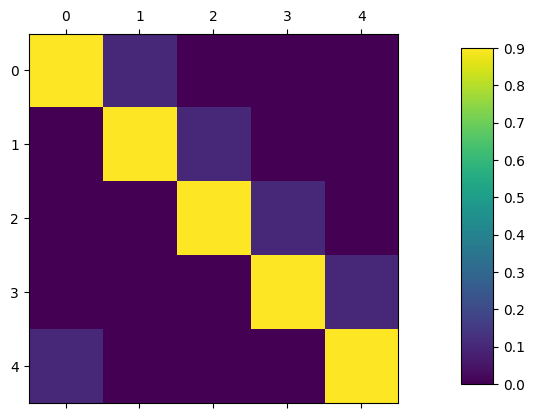

In [3]:
from osl_dynamics.utils import plotting

# Simulated transition probability matrix
sim_tp = sim.trans_prob

# Plot
plotting.plot_matrices(sim_tp)

We can see there's a high probability of a state remaining in the same state (`stay_prob` argument in `HMM_MVN`) and the only other non-zero probability is to transition to the next state in a sequence, i.e. state 1 goes to 2, 2 to 3, 3 to 4, etc.

Let's look at the hidden state time course we have simulated with the transition probability matrix.



(<Figure size 1200x250 with 2 Axes>, [<Axes: xlabel='Sample'>])

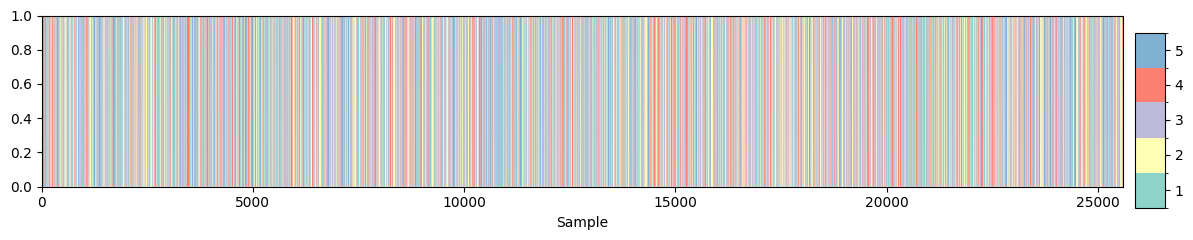

In [4]:
# Simulated state time course
sim_stc = sim.state_time_course

# Plot
plotting.plot_alpha(sim_stc)

Zooming into to the first 2000 samples, we see the state time course in more detail:



(<Figure size 1200x250 with 2 Axes>, [<Axes: xlabel='Sample'>])

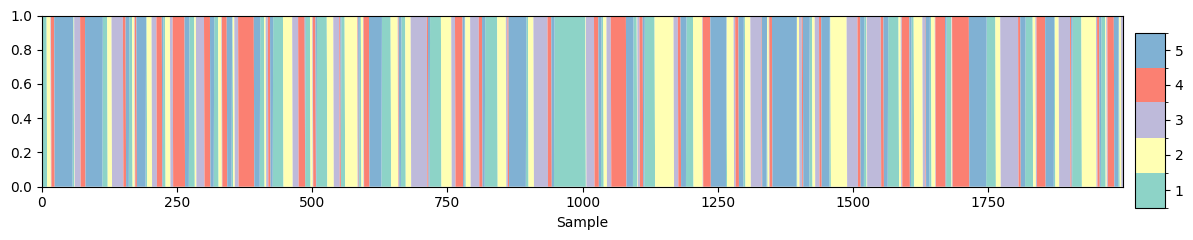

In [5]:
plotting.plot_alpha(sim_stc, n_samples=2000)

Finally, let's look at the simulated state covariances.



(<Figure size 640x480 with 6 Axes>,
 array([[<Axes: title={'center': 'State 1'}>,
         <Axes: title={'center': 'State 2'}>,
         <Axes: title={'center': 'State 3'}>],
        [<Axes: title={'center': 'State 4'}>,
         <Axes: title={'center': 'State 5'}>, <Axes: >]], dtype=object))

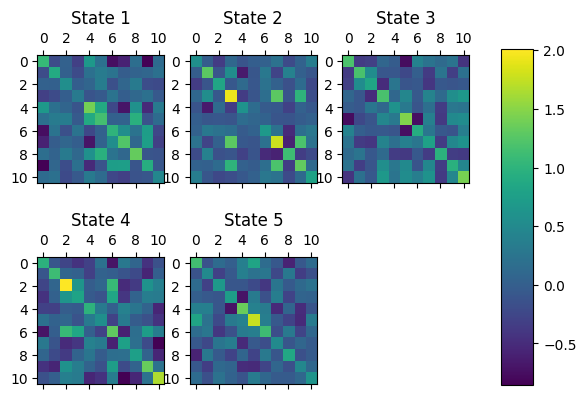

In [6]:
# Simulated covariances
sim_covs = sim.covariances

# Plot
plotting.plot_matrices(sim_covs, titles=[f"State {i}" for i in range(1, 6)])

We see each state has a unique covariance pattern. The hidden state at a particular time point determines which covariance is used to generate the observed data.

Finally, we load the simulated time series into an osl-dynamics [Data class](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/data/base/index.html#osl_dynamics.data.base.Data). This will be helpful for when we want to train a model.



In [12]:
ts.shape

(25600, 11)

In [7]:
from osl_dynamics.data import Data

# We can pass a numpy array directly to the Data class
training_data = Data(ts)

print(training_data)

/Users/apapathanasiou/miniconda3/envs/osld/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading files: 100%|██████████| 1/1 [00:00<00:00, 2857.16it/s]

Data
 id: 10822937632
 n_sessions: 1
 n_samples: 25600
 n_channels: 11


## Setting up the HMM
Next, let's setup an HMM in osl-dynamics to train on the simulated data.

### Specifying a Config object
The most important step is to specify the Config object, which is a class that acts as a container for all hyperparameters of a model. The API reference guide lists all the arguments for a Config object. Each model has its own Config object. For the HMM's Config object, the documentation is [here](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/models/hmm/index.html#osl_dynamics.models.hmm.Config). There are a lot of arguments that can be passed to this class, however, a lot of them have good default values you don't need to change.

The important hyperparameters to specify are:

- `n_states`, the number of states. Unfortunately, this is a hyperparameters that must be pre-specified. We advise starting with something between 6-14 and making sure any results based on the HMM are not critically sensitive to the choice for `n_states`.
- `sequence_length` and `batch_size`. We have found a sequence length between 100-400 works well. You want a large batch size for fast training. However, you will find that holding large batches of long sequences requires a lot of memory. Therefore, you should pick the largest values that you can hold in memory.
- `learn_means` and `learn_covariances`. Typically, if we train on amplitude envelope data we set `learn_means` and `learn_covariances` to `True`, whereas if you're training on time-delay embedded/PCA data, then we only learn the covariances, i.e. we set `learn_means=False`.
- `learning_rate`. On large datasets, we find a lower learning rate leads to a lower final loss. We recommend a value between 1e-2 and 1e-4. We advice training a few values and seeing which produces the lowest loss value.
- `n_epochs`, the number of epochs. This is the number of times you loop through the data. We recommend a value between 15-40. You can look at the loss as a function of epochs (see below) to see when the model has stopped improving. You can use this as an indicator for when you can stop training.

In this tutorial, we will set `n_states` to the ground truth we used in the simulation.



In [14]:
from osl_dynamics.models.hmm import Config

config = Config(
    n_states=5,
    n_channels=11,
    sequence_length=200,
    learn_means=False,
    learn_covariances=True,
    batch_size=16,
    learning_rate=0.01,
    n_epochs=30,
)

### Building a model
Now that we have our settings for the model in a Config object, the next step is to build the model. This can be done with the following lines.



In [9]:
from osl_dynamics.models.hmm import Model

# Initiate a Model class
model = Model(config)

Although the Model object is a custom class. It can be treated as a standard TensorFlow Keras model. It has all the attributes and methods of a Keras model. See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model) in TensorFlow for further details. We can use the `summary` method to view the model and its layers.



In [10]:
model.summary()

Model: "HMM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 200, 16)]    0           []                               
                                                                                                  
 tf.split (TFOpLambda)          [(None, 200, 11),    0           ['inputs[0][0]']                 
                                 (None, 200, 5)]                                                  
                                                                                                  
 static_loss_scaling_factor (St  ()                  0           ['tf.split[0][0]']               
 aticLossScalingFactorLayer)                                                                      
                                                                                                

We can see 4 layers in this model:

- The first is the `inputs` layer. This layer simply specifies what goes into the model. Here, it is a 3D tensor (which you can think of as just as array) of shape `(None, 200, 16)`. The `None` dimension will be the `batch_size` when the model is trained.
- The second layer is `tf.split`. The input to the model have the data concatenated with the state time course in the last dimension, i.e. we can see the last dimension in the input layer is `16`. This is the number of channels (`n_channels`, 11) plus the number of states (`n_states`, 5). The `tf.split` layer splits up the channels so we can access the channels and states as separate tensors. The input to this layer is `inputs[0][0]` and there are two outputs: `tf.split[0][0]` and `tf.split[0][1]`.
- Next we have the `means` layer. All this layer does is return the state means: `means[0][0]`. Although `tf.split[0][0]` is inputted to this layer, it is not used.
- Next we have the `covariances` layer. This layer returns the state covariances: `covs[0][0]`, again the input `tf.split[0][0]` is not used in the layer.
- Finally, the last layer is `ll_Loss`, which takes the channel data `tf.split[0][0]`, the state means `means[0][0]`, the state covariances `covs[0][0]` and the state time course `tf.split[0][1]` and calculates the negative log-likelihood loss. During training we try to minimise this loss by updating the state time course, state means and covariances.

## Training the HMM
Now we have build the model, we want to train it on the simulated data. Each model in osl-dynamics as a `fit` method, which makes training a model easy. To train a model we can just pass a Data object. The model knows for how long to train the model and what hyperparameters to use from the Config object that was used to create the model.



In [28]:
ts.shape

(25600, 11)

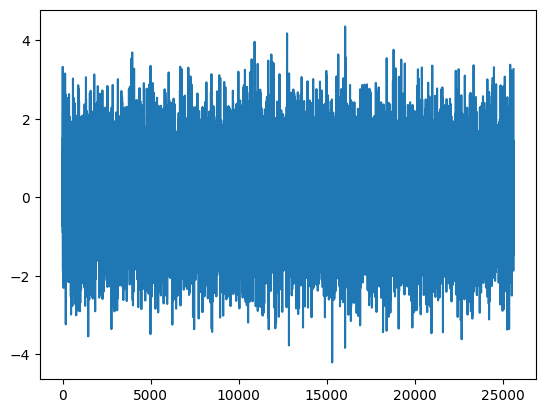

In [29]:
import matplotlib.pyplot as plt

plt.plot(ts[:,0])

In [13]:
# Train the model (should take less than a a minute on a fast computer)
history = model.fit(training_data)

# You should expect a speed of 50-90 ms/step on a CPU, or 25-50 ms/step on a single GPU

Epoch 1/30
8/8 [==============================] - 1s 60ms/step - rho: 0.2853 - lr: 0.0100 - loss: 2253.7958
Epoch 2/30
8/8 [==============================] - 0s 57ms/step - rho: 0.2094 - lr: 0.0090 - loss: 2225.4981
Epoch 3/30
8/8 [==============================] - 0s 58ms/step - rho: 0.1691 - lr: 0.0082 - loss: 2193.5206
Epoch 4/30
8/8 [==============================] - 0s 59ms/step - rho: 0.1436 - lr: 0.0074 - loss: 2136.5578
Epoch 5/30
8/8 [==============================] - 1s 63ms/step - rho: 0.1258 - lr: 0.0067 - loss: 2063.4762
Epoch 6/30
8/8 [==============================] - 0s 58ms/step - rho: 0.1125 - lr: 0.0061 - loss: 2003.4228
Epoch 7/30
8/8 [==============================] - 0s 57ms/step - rho: 0.1022 - lr: 0.0055 - loss: 1953.8644
Epoch 8/30
8/8 [==============================] - 0s 57ms/step - rho: 0.0939 - lr: 0.0050 - loss: 1914.8173
Epoch 9/30
8/8 [==============================] - 0s 58ms/step - rho: 0.0871 - lr: 0.0045 - loss: 1886.2989
Epoch 10/30
8/8 [===========

### The loss function
The `fit` method returns a `history` dictionary which records various values during training (as a function of epochs). It records all the various printed to screen during training (`rho`, `lr`, `loss`). Let's plot the loss from the `history` object.



(<Figure size 700x400 with 1 Axes>, <Axes: xlabel='Epoch', ylabel='Loss'>)

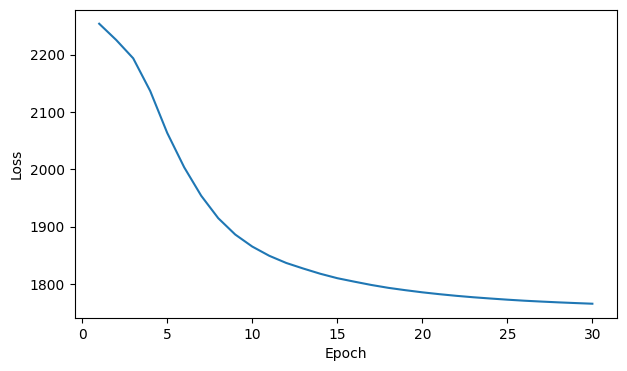

In [15]:
plotting.plot_line(
    [range(1, len(history["loss"]) + 1)],
    [history["loss"]],
    x_label="Epoch",
    y_label="Loss",
)

We can see as training progresses we reduce the loss. We also see the loss drops quickly at the start of training and slows down - the model is converging to a particular loss value. We can use the final loss as a metric to compare models - the lower the better. We want to train for enough epochs that the loss flattens off to a particular value.

## Getting Inferred Model Parameters
Now we have trained the model, we want to evaluate its performance. We measure performance using the loss and inferred model parameters (state time course, covariances, transition probability matrix). In this section, we demonstrate how to access these quantities from a trained model.

### State probabilities and state time course
The implementation of the HMM in osl-dynamics uses Bayesian inference for the state time course, i.e. it learns the probability of a state being active at each time point for the given dataset. Note, it learns point-estimates (i.e. is not Bayesian) when it learns an estimate for the state means/covariances.

Let's get the state probabilies inferred for the training data. We use the `Model.get_alpha` method of the model to get the inferred state probabilities.



In [16]:
# Get the inferred state probabilities for the training data
alpha = model.get_alpha(training_data)

2024-06-07 15:23:40 INFO osl-dynamics [hmm.py:1238:get_alpha]: Getting alpha


Let's print the shape of the `alpha` array to check that it matches the training data time series.



In [17]:
print(alpha.shape)
print(ts.shape)

(25600, 5)
(25600, 11)


Although the second dimension is different (because `alpha` is a `(n_samples, n_states)` array and `(n_samples, n_channels)` array), we can see the number of samples matches, which is good news.

Next, we want to get a state time course by taking the most probable state at each time point. The [inference.modes](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/inference/modes/index.html) module has useful functions for handling the inferred latent parameters of a model. We can use the [modes.argmax_time_courses](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/inference/modes/index.html#osl_dynamics.inference.modes.argmax_time_courses) to get the state time course in a one-hot encoded format.



In [18]:
from osl_dynamics.inference import modes

# Take the most probably state to get a state time course
inf_stc = modes.argmax_time_courses(alpha)

# Printing the inf_stc array, we see it is binary.
# The column with a value of 1 indicates which state is active
print(inf_stc)

[[0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]
 ...
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]


We see from this state time course that the second state is active for the first few time points and the first state is active for the last few time points.

### Inferred state covariances
Next, let's get the inferred state covariances. The `hmm.Model` class has a `get_covariances` method for this. Note, it also has a `get_means_covariances` method if you wanted to get the inferred state means and covariances together.



In [19]:
inf_covs = model.get_covariances()

### Transition probability matrix
Finally, let's get the inferred transition probabiltiy matrix using the `get_trans_prob` method.



In [20]:
inf_tp = model.get_trans_prob()

### Comparing inferred vs ground truth parameters
Let's now see how well the model did in inferring the parameters we used to simulate the data. Before we can compare the inferred parameters to the ground truth, we need to make sure we're comparing the correct states. There is a trivial identifiability problem with the HMM, the label for a state cannot be learnt. In other words, state 1 in the simulation might be learnt as state 3 in the inference. To fix this we can re-order the inferred states to match the simulation before comparing inferred vs ground truth parameters. Let's first do this.



In [21]:
import numpy as np

# Get the order that matches the states
_, order = modes.match_modes(sim_stc, inf_stc, return_order=True)

# Re-order the inferred parameters
inf_stc_ord = inf_stc[:, order]
inf_covs_ord = inf_covs[order]
inf_tp_ord = inf_tp[np.ix_(order, order)]

Now that we have matched the ordering of the inferred states to the simulation, let's compare the inferred parameters to the ground truth.



(<Figure size 1200x500 with 3 Axes>,
 array([<Axes: ylabel='Ground Truth'>,
        <Axes: xlabel='Sample', ylabel='Inferred'>], dtype=object))

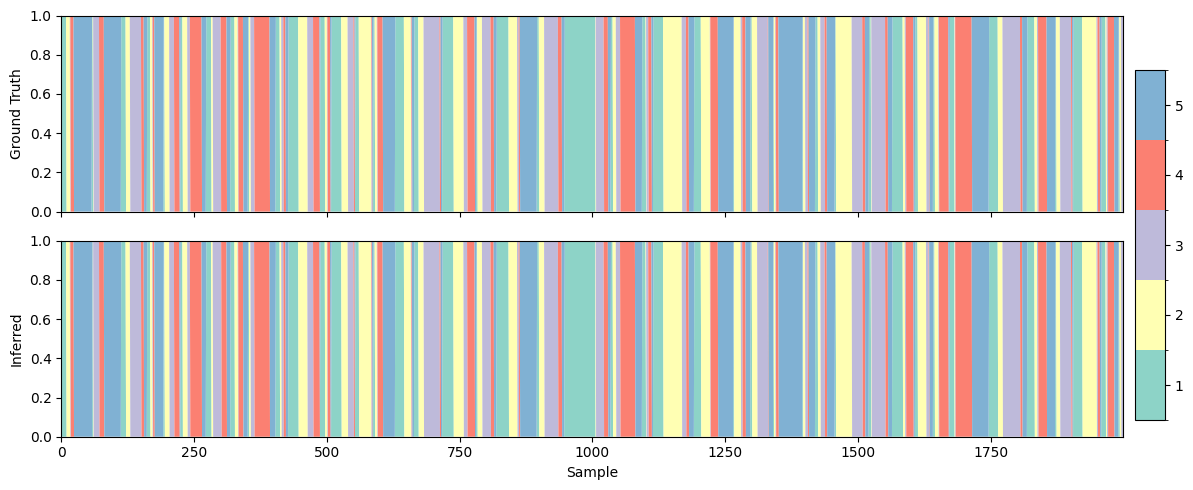

In [22]:
# Compare the state time courses
plotting.plot_alpha(
    sim_stc,
    inf_stc_ord,
    n_samples=2000,
    y_labels=["Ground Truth", "Inferred"],
)

To compare the state time courses more quantitatively, we can use a metric known as the 'Dice coefficient'. You can think of this metric simply as the accuracy: 1 means a perfect match, 0 means a very bad match. This metric could also be used as a measure of how similar two state time courses are. Let's calculate the dice coefficient using the inferred and ground truth state time course.



In [23]:
from osl_dynamics.inference import metrics

print("Dice coefficient:", metrics.dice_coefficient(sim_stc, inf_stc_ord))

Dice coefficient: 0.9994140625


We can see it is almost perfect.



In [ ]:
# Compare the covariances
plotting.plot_matrices(sim_covs, main_title="Ground Truth")
plotting.plot_matrices(inf_covs_ord, main_title="Inferred")

# Compare the transition probabilty matrices
plotting.plot_matrices([sim_tp, inf_tp_ord], titles=["Ground Truth", "Inferred"])

We can see all the parameters have been inferred correctly, therefore we can have confidence the HMM is working well.

## Post-hoc Analysis
Once, you have trained an HMM and retrieved the inferred state time course. Most analysis is based on interpreting the state time course and calculating quantities based on the state time course.

### Summary statistics
A common analysis is to calculate summary statistics based on the state time course. The [inference.modes](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/inference/modes/index.html) module has many functions from calculating various summary statistics using the state time course.

A popular statistic is the **fractional occupancy**, this is the fraction of the total time series spent in a particular state. Let's calculate this using the [modes.fractional_occupancies](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/inference/modes/index.html#osl_dynamics.inference.modes.fractional_occupancies) function.



In [ ]:
fo = modes.fractional_occupancies(inf_stc)

print("Fractional occupancies:", fo)

We see the fractional occupany is roughly equal for each state, meaning the total time spent in each state is roughly equal.

Another popular summary statistic is the mean lifetime time, this is the average duration a state is active. Let's calculate this using the [modes.mean_lifetimes](https://osl-dynamics.readthedocs.io/en/latest/autoapi/osl_dynamics/inference/modes/index.html#osl_dynamics.inference.modes.mean_lifetimes) function.



In [ ]:
mlt = modes.mean_lifetimes(inf_stc)

print("Mean lifetimes:", mlt)

We see the mean lifetime is roughly equaly for each state.

## Wrap up
- We have shown how to simulate HMM data.
- We have shown how to setup an HMM in osl-dynamics and train this model on data.
- We have done some basic analysis of the inferred parameters of an HMM.

